In [1]:
!pip install python-docx Pillow pytesseract PyPDF2
!apt-get install -y tesseract-ocr
!pip install pyspellchecker
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 14.7 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,727 kB/s)
Selecting

In [2]:
from transformers import pipeline
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch
import re
import json
from spellchecker import SpellChecker  # For spelling and grammar checks
from PIL import Image
import pytesseract
import PyPDF2
import docx
import os
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from datetime import datetime

In [3]:
def extract_from_pdf(file_bytes):
    reader = PyPDF2.PdfReader(io.BytesIO(file_bytes))
    text = ''
    for page in reader.pages:
        text += page.extract_text()
    return text
def extract_from_docx(file_bytes):
    doc = docx.Document(io.BytesIO(file_bytes))
    return '\n'.join(paragraph.text for paragraph in doc.paragraphs)
def extract_from_image(file_bytes):
    image = Image.open(io.BytesIO(file_bytes))
    return pytesseract.image_to_string(image)
def extract_from_txt(file_bytes):
    return file_bytes.decode('utf-8')
def process_file():
    uploaded = files.upload()
    extracted_text = ""

    for filename, content in uploaded.items():
        file_extension = os.path.splitext(filename)[1].lower()

        try:
            if file_extension == '.pdf':
                extracted_text = extract_from_pdf(content)
            elif file_extension == '.docx':
                extracted_text = extract_from_docx(content)
            elif file_extension in ['.png', '.jpg', '.jpeg']:
                extracted_text = extract_from_image(content)
            elif file_extension == '.txt':
                extracted_text = extract_from_txt(content)
            else:
                return f"Unsupported file format: {file_extension}"

        except Exception as e:
            return f"Error processing {filename}: {str(e)}"

    return extracted_text

In [4]:
class QuestionSystem:
    def __init__(self):
        self.question_generator = pipeline("text2text-generation", model="google/flan-t5-large")
        self.similarity_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.qa_pairs = []
        self.student_responses = {
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'questions': [],
            'total_time': 0,
            'total_score': 0
        }

    def generate_questions(self, text, num_questions=4, pool_size=10):
        theory_prompts = [
            f"Generate a detailed theoretical question about this concept: {text}",
            f"Ask a question that requires explaining a concept from this text: {text}",
            f"Create a question that tests deep understanding of: {text}",
            f"Form a question that requires detailed explanation of a topic from: {text}",
            f"Generate a question that explores the implications of: {text}",
            f"Ask a question that requires critical analysis of: {text}",
            f"Create a question that tests application of: {text}",
            f"Form a question that requires comparison of concepts from: {text}",
            f"Generate a question that evaluates the significance of: {text}",
            f"Ask a question that requires synthesis of ideas from: {text}"
        ]

        generated_questions = []

        # Generate a pool of questions
        for prompt in theory_prompts[:pool_size]:
            question = self.question_generator(prompt, max_length=100, num_return_sequences=1)[0]['generated_text']
            answer = self.question_generator(f"Provide a detailed answer for: {question}\n\nBased on text: {text}",
                                          max_length=200, num_return_sequences=1)[0]['generated_text']

            generated_questions.append({
                'question': question,
                'answer': answer
            })

        # Randomly select 4 distinct questions
        selected_questions = self.select_distinct_questions(generated_questions, num_questions)
        self.qa_pairs = selected_questions

    def select_distinct_questions(self, questions, num_questions, threshold=0.7):
        selected_questions = []
        remaining_questions = questions.copy()

        while len(selected_questions) < num_questions and remaining_questions:
            # Randomly pick a question
            question = random.choice(remaining_questions)
            remaining_questions.remove(question)

            # Check if the question is distinct from already selected questions
            is_distinct = True
            for selected_question in selected_questions:
                similarity = float(util.pytorch_cos_sim(
                    self.similarity_model.encode(question['question'], convert_to_tensor=True),
                    self.similarity_model.encode(selected_question['question'], convert_to_tensor=True)
                )[0][0])
                if similarity > threshold:
                    is_distinct = False
                    break

            if is_distinct:
                selected_questions.append(question)

        return selected_questions

    def check_answer(self, user_answer, correct_answer):
        similarity = float(util.pytorch_cos_sim(
            self.similarity_model.encode(user_answer, convert_to_tensor=True),
            self.similarity_model.encode(correct_answer, convert_to_tensor=True)
        )[0][0])
        return similarity

    def calculate_marks(self, similarity):
        return round(similarity * 5, 2)  # Max 5 marks based on similarity

    def save_session_data(self, filename='student_responses.json'):
        with open(filename, 'w') as f:
            json.dump(self.student_responses, f, indent=2)

def run_quiz():
    qs = QuestionSystem()
    qs.generate_questions(text)

    total_time = 0
    total_score = 0

    for i, qa in enumerate(qs.qa_pairs, 1):
        print(f"\nQuestion {i}: {qa['question']}")

        start_time = time.time()
        user_answer = input("Your answer: ")
        time_taken = round(time.time() - start_time, 2)

        similarity = qs.check_answer(user_answer, qa['answer'])
        marks = qs.calculate_marks(similarity)

        response_data = {
            'question': qa['question'],
            'correct_answer': qa['answer'],
            'user_answer': user_answer,
            'time_taken': time_taken,
            'similarity': round(similarity * 100, 2),
            'marks': marks
        }

        qs.student_responses['questions'].append(response_data)
        total_time += time_taken
        total_score += marks

        print(f"Time taken: {time_taken} seconds")
        print(f"Similarity: {similarity * 100:.2f}%")
        print(f"Marks: {marks}/5")

    qs.student_responses['total_time'] = round(total_time, 2)
    qs.student_responses['total_score'] = round(total_score, 2)

    print(f"\nQuiz Summary:")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Total score: {total_score:.2f}/20")
    print(f"Average time per question: {total_time/4:.2f} seconds")

    if round(total_score) < 8:
        print(f"Result: Fail")
    else:
        print(f"Result: Pass")

    qs.save_session_data()


In [5]:
class ResponseAnalyzer:
    def __init__(self):
        # Load a better AI detection model (e.g., OpenAI's GPT-based model or other reliable models)
        self.ai_detector = pipeline("text-classification",
                                  model="roberta-base-openai-detector",  # Replace with a better model
                                  device=0 if torch.cuda.is_available() else -1)
        self.similarity_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        self.min_word_count = 50  # Minimum word count to consider AI-generated text
        self.spell_checker = SpellChecker()  # For spelling and grammar checks

    def check_ai_generated(self, text):
        """Check if text is AI generated, with adjustments for word count, spelling, and grammar."""
        word_count = len(text.split())

        # Check for poor spelling and grammar
        misspelled = self.spell_checker.unknown(text.split())
        misspelled_count = len(misspelled)

        # Determine if the text is grammatically correct and spelled correctly
        is_grammatically_correct = misspelled_count == 0  # Assume no misspelled words means grammatically correct

        # Conditions for AI-generated text
        is_long_text = word_count > self.min_word_count
        is_well_written = is_grammatically_correct

        # Calculate AI probability based on conditions
        if is_long_text and is_well_written:
            # If all conditions are met, it's most likely AI-generated
            ai_probability = 90.0  # High probability
        elif is_long_text or is_well_written:
            # If at least one condition is met, assign neutral probability
            ai_probability = 50.0  # Neutral probability
        else:
            # If no conditions are met, it's unlikely to be AI-generated
            ai_probability = 0.0  # Low probability

        # Use the AI detector to refine the probability if conditions are met
        if is_long_text or is_well_written:
            result = self.ai_detector(text)
            detector_probability = round(result[0]['score'] * 100, 2)
            # Blend the detector probability with the condition-based probability
            ai_probability = (ai_probability + detector_probability) / 2

        # Ensure AI probability is within bounds
        ai_probability = max(0, min(100, ai_probability))

        return round(ai_probability, 2)

    def check_plagiarism(self, student_answer, reference_text):
        """Check plagiarism against reference text"""
        # Split reference text into chunks
        chunks = [s.strip() for s in reference_text.split('.') if s.strip()]

        # Get embeddings
        student_embedding = self.similarity_model.encode(student_answer, convert_to_tensor=True)
        chunk_embeddings = self.similarity_model.encode(chunks, convert_to_tensor=True)

        # Calculate similarities
        similarities = util.pytorch_cos_sim(student_embedding, chunk_embeddings)
        max_similarity = float(torch.max(similarities)) * 100

        return round(max_similarity, 2)

def analyze_responses(json_file='student_responses.json'):
    # Load the analyzer
    analyzer = ResponseAnalyzer()

    # Read existing responses
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Create lists for DataFrame
    records = []

    # Analyze each response
    for q_data in data['questions']:
        ai_score = analyzer.check_ai_generated(q_data['user_answer'])
        plagiarism_score = analyzer.check_plagiarism(q_data['user_answer'], q_data['correct_answer'])

        record = {
            'question': q_data['question'],
            'user_answer': q_data['user_answer'],
            'correct_answer': q_data['correct_answer'],
            'time_taken': q_data['time_taken'],
            'similarity_score': q_data['similarity'],
            'marks': q_data['marks'],
            'ai_generated_probability': ai_score,
            'plagiarism_probability': plagiarism_score
        }
        records.append(record)

    # Create DataFrame
    df = pd.DataFrame(records)

    # Save to CSV
    csv_filename = 'student_responses_analysis.csv'
    df.to_csv(csv_filename, index=False)

    # Update JSON with new metrics
    for i, q_data in enumerate(data['questions']):
        q_data['ai_generated_probability'] = float(records[i]['ai_generated_probability'])
        q_data['plagiarism_probability'] = float(records[i]['plagiarism_probability'])

    with open(json_file, 'w') as f:
        json.dump(data, f, indent=2)

    # Print summary
    print("\nAnalysis Summary:")
    print(f"Average AI Generation Probability: {df['ai_generated_probability'].mean():.2f}%")
    print(f"Average Plagiarism Probability: {df['plagiarism_probability'].mean():.2f}%")
    print(f"\nDetailed analysis saved to {csv_filename}")

    return df

In [6]:
def plot_graph():
  # Load the CSV data into a DataFrame
  df = pd.read_csv('student_responses_analysis.csv')
  # Replace actual questions with Q1, Q2, Q3, Q4 for better readability
  df['question'] = ['Q1', 'Q2', 'Q3', 'Q4']

  # Load the CSV data into a DataFrame
  df = pd.read_csv('student_responses_analysis.csv')

  # Create a large figure with 6 subplots
  fig, axes = plt.subplots(3, 2, figsize=(20, 20))
  fig.suptitle('Student Responses Analysis', fontsize=16)

  # Flatten the axes array for easier indexing
  axes = axes.flatten()

  # Plot 1: Marks vs Question (Bar Graph)
  sns.barplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['marks'], hue=['Q1', 'Q2', 'Q3', 'Q4'], ax=axes[0], palette='viridis', legend=False)
  axes[0].set_title('Marks vs Question')
  axes[0].set_xlabel('Question')
  axes[0].set_ylabel('Marks')

  # Plot 2: Time vs Question
  sns.lineplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['time_taken'], ax=axes[1], marker='o', color='orange')
  axes[1].set_title('Time Taken vs Question')
  axes[1].set_xlabel('Question')
  axes[1].set_ylabel('Time Taken (seconds)')

  # Plot 3: AI Generated Probability and Plagiarism Probability
  sns.lineplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['ai_generated_probability'], ax=axes[2], marker='o', label='AI Generated Probability', color='blue')
  sns.lineplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['plagiarism_probability'], ax=axes[2], marker='o', label='Plagiarism Probability', color='red')
  axes[2].set_title('AI Generated vs Plagiarism Probability')
  axes[2].set_xlabel('Question')
  axes[2].set_ylabel('Probability')
  axes[2].legend()

  # Plot 4: Similarity of User Answer vs Correct Answer
  sns.barplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['similarity_score'], hue=['Q1', 'Q2', 'Q3', 'Q4'], ax=axes[3], palette='coolwarm', legend=False)
  axes[3].set_title('Similarity Score vs Question')
  axes[3].set_xlabel('Question')
  axes[3].set_ylabel('Similarity Score')

  # Plot 5: AI Generated Probability vs Question
  sns.barplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['ai_generated_probability'], hue=['Q1', 'Q2', 'Q3', 'Q4'], ax=axes[4], palette='magma', legend=False)
  axes[4].set_title('AI Generated Probability vs Question')
  axes[4].set_xlabel('Question')
  axes[4].set_ylabel('AI Generated Probability')

  # Plot 6: Plagiarism Probability vs Question
  sns.barplot(x=['Q1', 'Q2', 'Q3', 'Q4'], y=df['plagiarism_probability'], hue=['Q1', 'Q2', 'Q3', 'Q4'], ax=axes[5], palette='plasma', legend=False)
  axes[5].set_title('Plagiarism Probability vs Question')
  axes[5].set_xlabel('Question')
  axes[5].set_ylabel('Plagiarism Probability')

  # Adjust layout and show plot
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

In [7]:
text=process_file() #Accepts text,docs,pdf,Images
text = text.replace("\n", " ").replace(":", "\n").replace("-", "\n").replace(".", "\n").replace("*", "\n")

Saving Module 6.pdf to Module 6.pdf


In [8]:
# Run the system
run_quiz()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors



Question 1: What is the term for a technique that uses keyframes to define the starting and ending points of an object or character's movement or pose?
Your answer: frame by frame buffer
Time taken: 135.28 seconds
Similarity: 28.83%
Marks: 1.44/5

Question 2: What is the difference between a frame by frame and a motion capture?
Your answer: in frame by frame a frame is considered while in motion capture a instance is considered
Time taken: 27.57 seconds
Similarity: 52.74%
Marks: 2.64/5

Question 3: What is the main purpose of this module?
Your answer: to provide instance
Time taken: 14.97 seconds
Similarity: 9.73%
Marks: 0.49/5

Question 4: What is the main difference between the two approaches?
Your answer: way of exceution 
Time taken: 11.35 seconds
Similarity: 4.12%
Marks: 0.21/5

Quiz Summary:
Total time: 189.17 seconds
Total score: 4.78/20
Average time per question: 47.29 seconds
Result: Fail


In [9]:
df = analyze_responses()
# Display sample analysis
print("\nDetailed Analysis per Question:")
for idx, row in df.iterrows():
  print(f"\nQuestion {idx + 1}:")
  print(f"AI Generated Probability: {row['ai_generated_probability']}%")
  print(f"Plagiarism Probability: {row['plagiarism_probability']}%")
  print("-" * 50)

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu



Analysis Summary:
Average AI Generation Probability: 52.69%
Average Plagiarism Probability: 23.86%

Detailed analysis saved to student_responses_analysis.csv

Detailed Analysis per Question:

Question 1:
AI Generated Probability: 73.7%
Plagiarism Probability: 28.83%
--------------------------------------------------

Question 2:
AI Generated Probability: 69.67%
Plagiarism Probability: 52.74%
--------------------------------------------------

Question 3:
AI Generated Probability: 67.37%
Plagiarism Probability: 9.73%
--------------------------------------------------

Question 4:
AI Generated Probability: 0.0%
Plagiarism Probability: 4.12%
--------------------------------------------------


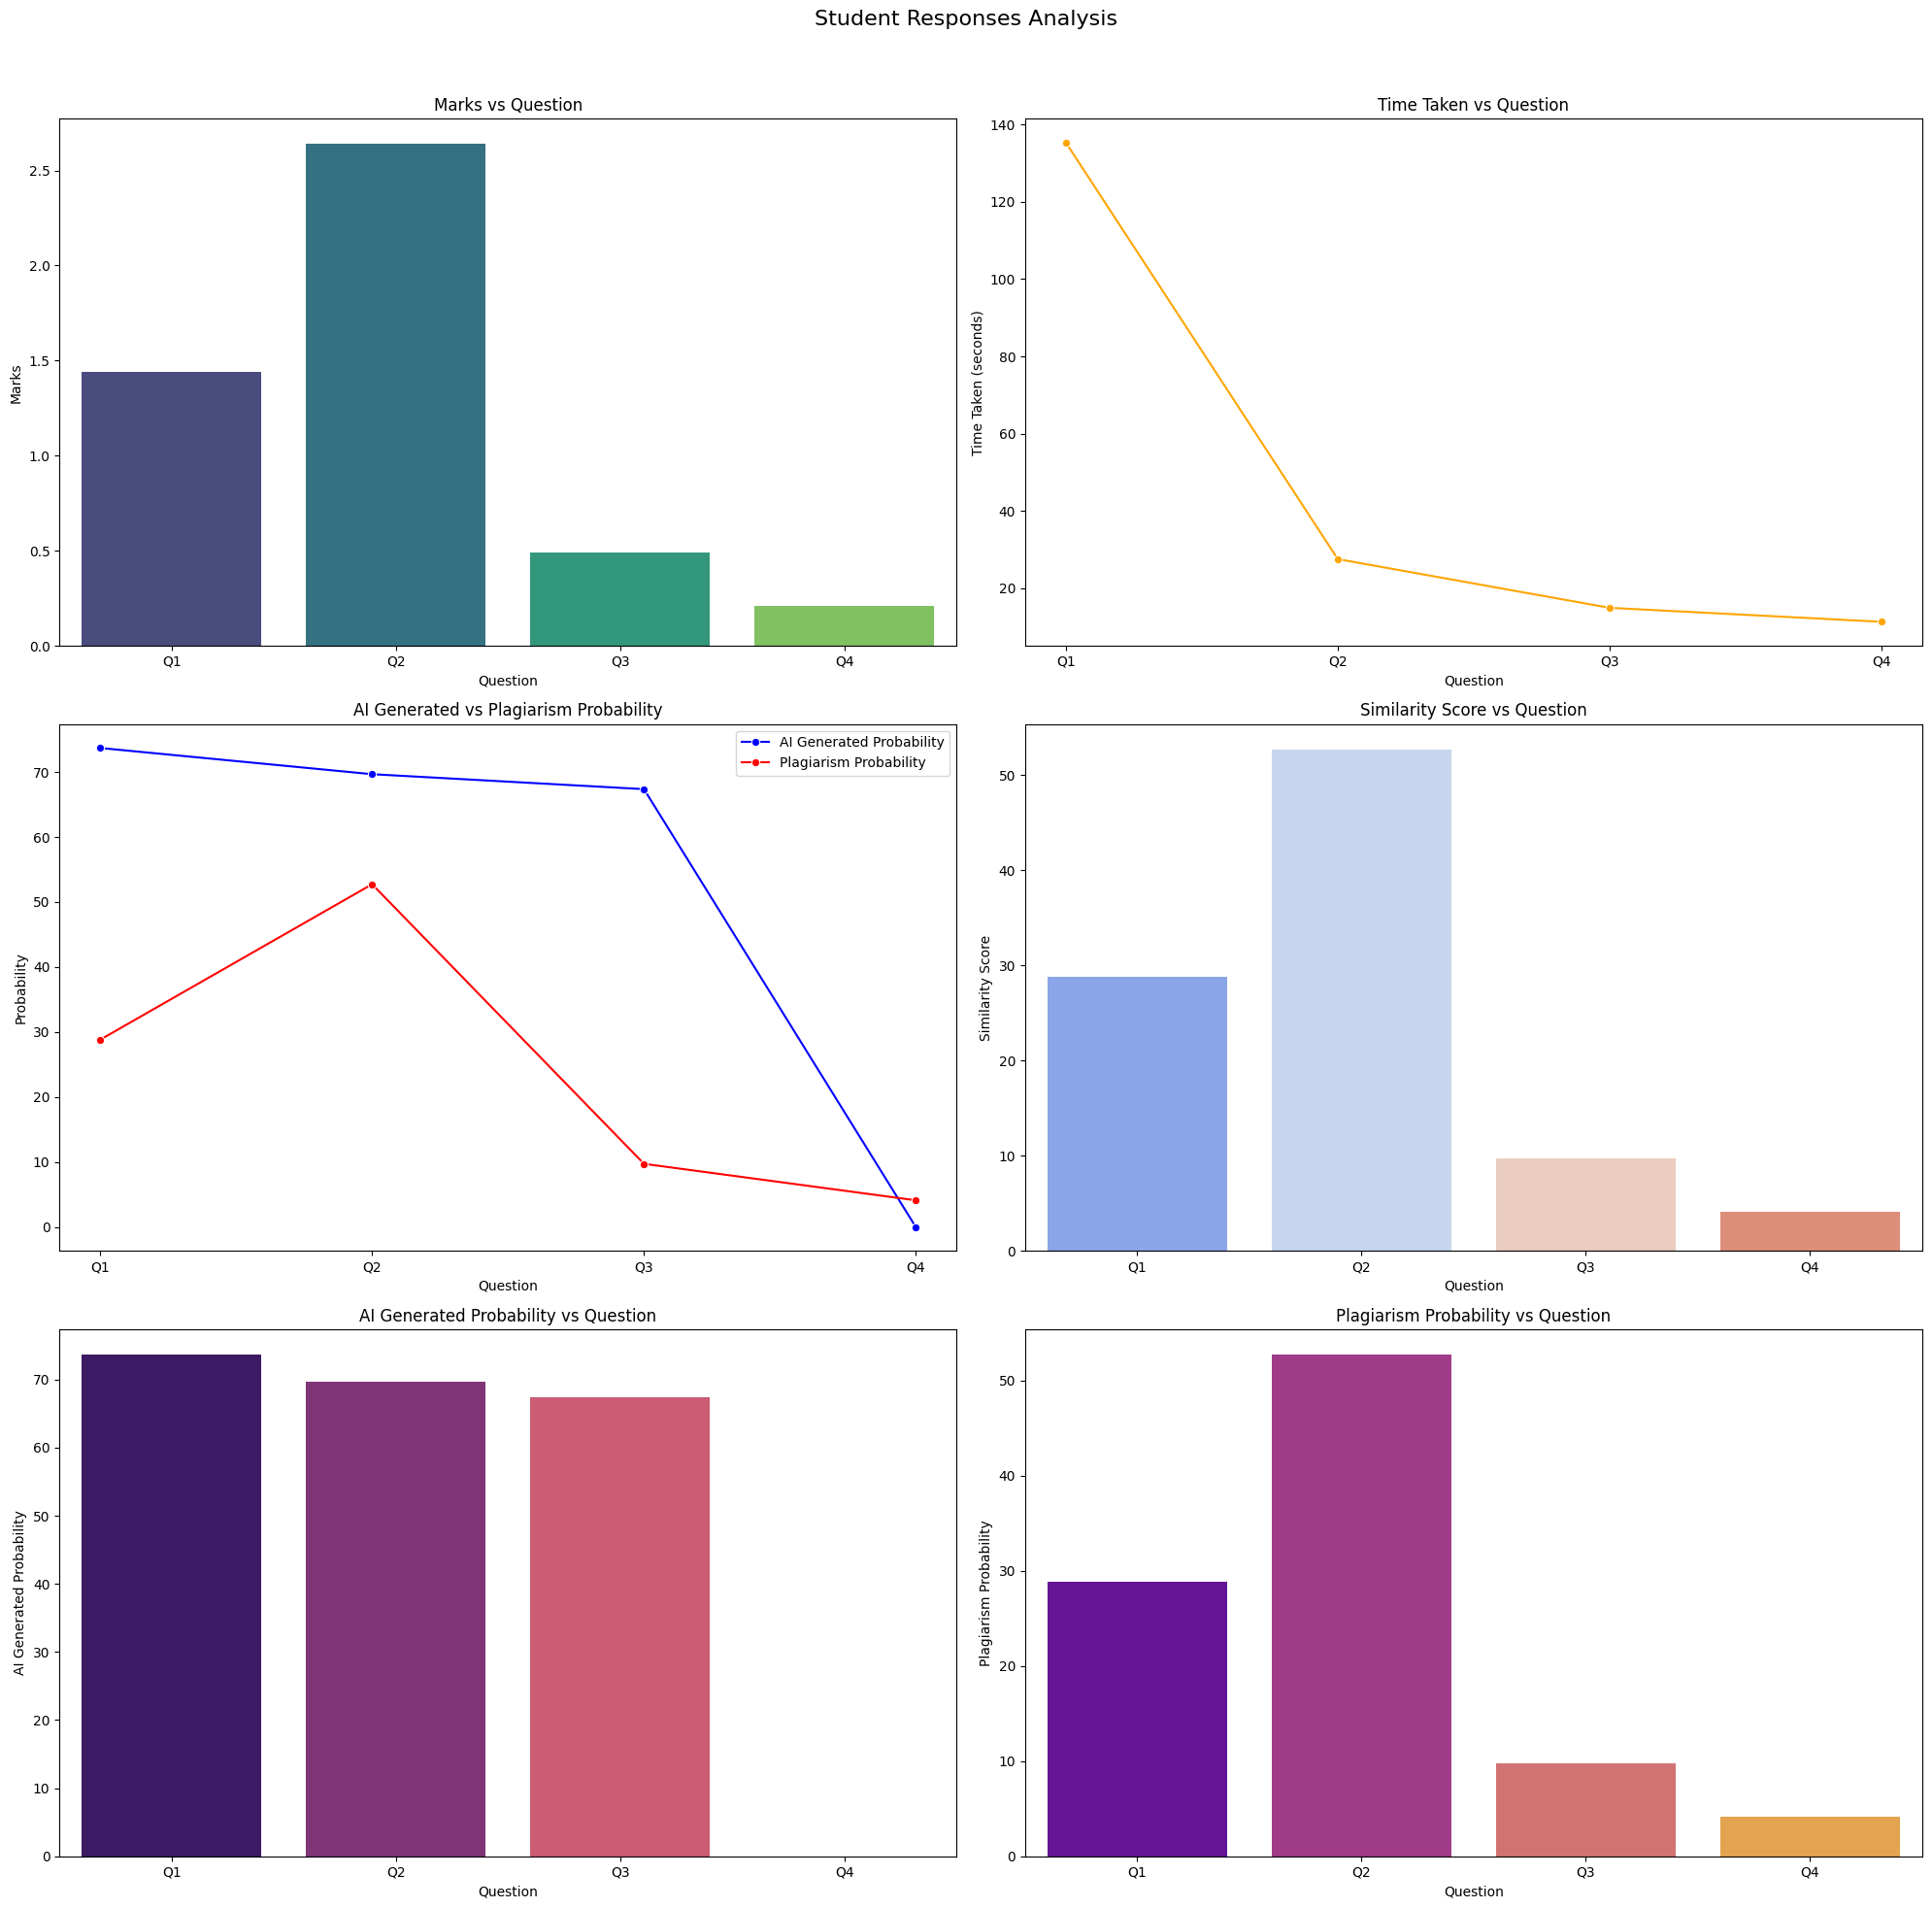

In [10]:
plot_graph()